# Auto Level Set Liver Tumor Segmentation

In [1]:
import math
import os
import random
import sys
import time

import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from scipy import ndimage as ndi
from scipy.signal import find_peaks
from skimage import segmentation
from skimage.filters import sobel
from skimage.segmentation import chan_vese
from skimage.util import montage
from tqdm.notebook import tqdm
from matplotlib.pyplot import figure

In [2]:
# https://stackoverflow.com/questions/39206986/numpy-get-rectangle-area-just-the-size-of-mask

In [7]:
# Main Folder Dir
fp = '/data/Collin/Liver_Tumor_Segmentation_Methods/Original_ISMRM'
#     C:\\Users\\colli\\Desktop\\lesionInterfaces\\\ISMRM_AutoLevelSet\\WC-IRB1308014251_008

# Utility variables
splitter = '/'

# Pandas dataframe to store everything
"""
Shorthand meanings
    - 'vol' = original image volume
    - 'GT' = ground truth segmentation
    - 'MS' = Manual Segmentation
    - 'SC' = Smart Click Segmentation
    - 'LS' = Level Set Segmentation
"""

# Maping file names to respective categories
file_map = {
    'vol' : 'dicom_vol',
    'LM' : 'pred_vol',
    'GT' : 'GT_liver_cyst_vol',
    'MS' : 'DR_liver_cyst_vol',
    'SC' : 'DR_liver_cyst_smart_click_vol',
    'JLRM' : 'JL_liver_roughMax_vol',
    'LS' : 'CL_liver_cyst_watershed_LM_vol'}

inv_file_map = {v: k for k, v in file_map.items()}

### Utils

In [8]:
def openImage(fp):
    """
    Open up nifty image and convert to numpy arrays

    Paramaters
    ----------
    fp: string
        The file path to the nifty image

    Returns
    ----------
    nii: nibabel image object
    img: numpy array
    vol: volume of image in cm³
    """
    
    if (not fp) or ('nii' not in fp):
        return

    nii = nib.load(fp)
    sx, sy, sz = nii.header.get_zooms()
    
    return nii, nii.get_fdata(), sx*sy*sz/10

def organizeFiles(fp):
    """
    Organize nifty files into array
    
    Parameters
    ----------
    fp: string
        The file path to the folder containing nifty images

    Returns
    ----------
    arr: array of file paths to numpy images
    """

    arr = []
    for f in os.listdir(fp):
        if 'nii' in f:
            arr.append(os.path.join(fp, f))
    return arr

def organizeFolders(fp):
    """
    Organize folders into array
    
    Paramaters
    ----------
    fp: string
        The file path to the folder containing nifty images

    Returns
    ----------
    arr: array of file paths to folders
    """

    print('DEBUG: list directories -', os.listdir(fp))

    arr = []
    for f in os.listdir(fp):
        if os.path.isdir(os.path.join(fp, f)):
            arr.append(os.path.join(fp, f))
    return arr


In [9]:
def display2D3D(img_tensor, msk_tensor, prd_tensor, threshold=0.1, alpha1=0.1, alpha2=0.5, cmap=['bone', 'cool', 'autumn'], edges=False):
    """
    Beautifully display 2D and 3D images
    """
    
    img_tensor = img_tensor.copy().squeeze()
    msk_tensor = msk_tensor.copy().squeeze()
    prd_tensor = prd_tensor.copy().squeeze()
    if prd_tensor.min() < 0 or prd_tensor.max() > 1:
        prd_tensor = 1/(1 + np.exp(-prd_tensor))

    print('img_tensor mean, std, min, max', img_tensor.mean(), img_tensor.std(), img_tensor.min(), img_tensor.max(), img_tensor.shape)
    print('msk_tensor mean, std, min, max', msk_tensor.mean(), msk_tensor.std(), msk_tensor.min(), msk_tensor.max(), msk_tensor.shape)
    print('Prd_tensor mean, std, min, max', prd_tensor.mean(), prd_tensor.std(), prd_tensor.min(), prd_tensor.max(), prd_tensor.shape)

    prd_tensor[prd_tensor < threshold] = np.float32(0)
    prd_tensor = np.asarray(prd_tensor, dtype=np.float32)

    #   print("Num uniq img values:", np.unique(img_tensor, return_counts=True))
    #   print("Num uniq msk values:", np.unique(msk_tensor, return_counts=True))
    #   print("Num uniq prd values:", np.unique(prd_tensor, return_counts=True))

    img_tensor = np.moveaxis(img_tensor, -1, 0)
    msk_tensor = np.moveaxis(msk_tensor, -1, 0)
    prd_tensor = np.moveaxis(prd_tensor, -1, 0)

    # for i in range(img_tensor.shape[0]):
    #     img_tensor[i, :, :] = np.rot90(np.flipud(img_tensor[i, :, :]), k=1)
    #     msk_tensor[i, :, :] = np.rot90(np.flipud(msk_tensor[i, :, :]), k=1)
    #     prd_tensor[i, :, :] = np.rot90(np.flipud(prd_tensor[i, :, :]), k=1)

        # img_tensor[i, :, :] = np.flip(np.rot90(img_tensor[i, :, :], k=1))
        # msk_tensor[i, :, :] = np.flip(np.rot90(msk_tensor[i, :, :], k=1))
        # prd_tensor[i, :, :] = np.flip(np.rot90(prd_tensor[i, :, :], k=1))

    min_value = 0
    max_value = img_tensor.shape[0]
    for i in range(0, img_tensor.shape[0], 1):
      if msk_tensor[i, :, :].sum() != 0 and prd_tensor[i, :, :].sum() != 0:
        min_value = i - 1 # extra padding
        break

    for i in range(img_tensor.shape[0]-1, 0, -1):
      print(i, end=' ')
      if msk_tensor[i, :, :].sum() != 0 and prd_tensor[i, :, :].sum() != 0:
        max_value = i + 2 # extra padding
        break

    if not edges:
      img_tensor = img_tensor[min_value:max_value, :, :]
      msk_tensor = msk_tensor[min_value:max_value, :, :]
      prd_tensor = prd_tensor[min_value:max_value, :, :]
    
    img_tensor = np.rot90(np.flipud(montage(img_tensor)), k=-1)
    msk_tensor = np.rot90(np.flipud(montage(msk_tensor)), k=-1)
    prd_tensor = np.rot90(np.flipud(montage(prd_tensor)), k=-1)

    print('Init types (img, msk, prd):', img_tensor.dtype, msk_tensor.dtype, prd_tensor.dtype)

    fig, ax = plt.subplots(1, 1, figsize = (20, 20))
    ax.imshow(img_tensor, cmap = cmap[0])
    ax.imshow(np.ma.masked_where(msk_tensor == 0, msk_tensor), cmap=cmap[1], alpha=alpha1)
    ax.imshow(np.ma.masked_where(prd_tensor == 0, prd_tensor), cmap=cmap[2], alpha=alpha2)
    plt.show()

### [Chan-Vese Segmentation](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.chan_vese) method - This version is written by Hang Zhang.

In [ ]:
# Initial values: mu, nu, max_iter, epison, step = 1, 0.2, 30, 0.1, 0.1

def normMinMax(img, msk=None, p_val=None, ll=0, rr=255):
    """
    Min-Max Normalization

    Parameters
    ----------
    img: numpy array
    msk: numpy array
    p_val: float
    ll: float
    rr: float

    Returns
    ----------
    img: numpy array
    """

    new_img = np.zeros(img.shape)
    if msk is not None:
        min_val = np.min(img[msk > 0])
        max_val = np.max(img[msk > 0])
        new_img = (img - min_val) / (max_val - min_val) * (rr-ll) + ll
    else:
        min_val = np.min(img)
        max_val = np.max(img)
        new_img = ( (img - min_val) / (max_val - min_val) ) * (rr-ll) + ll

    if p_val is not None:
        p_val = (p_val - min_val) / (max_val - min_val) * (rr-ll) + ll

        return new_img, p_val

    return new_img

def argwhere_app(a): # @Jörn Hees's soln: https://stackoverflow.com/questions/48987774/how-to-crop-a-numpy-2d-array-to-non-zero-values
    coords = np.argwhere(a)
    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)
    return x_min, x_max+1, y_min, y_max+1

def iterateChanVese(lsf, img, mu, nu, epison, step):
    """
    Iterate Chan-Vese algorithm
    
    Parameters
    ----------
    lsf: numpy array
    img: numpy array
    mu: float
    nu: float
    epison: float
    step: float

    Returns
    ----------
    lsf: numpy array segmentation
    """

    Drc = (epison / math.pi) / (epison*epison + lsf*lsf)
    Hea = 0.5*(1 + (2 / math.pi) * np.arctan(lsf/epison))
    Iy, Ix = np.gradient(lsf)
    s = np.sqrt(Ix*Ix+Iy*Iy)
    Nx = Ix / (s+1e-6)
    Ny = Iy / (s+1e-6)
    Mxx, Nxx = np.gradient(Nx)
    Nyy, Myy = np.gradient(Ny)
    cur = Nxx + Nyy
    Length = nu*Drc*cur

    Lap = cv2.Laplacian(lsf, -1)
    Penalty = mu*(Lap - cur)

    s1 = Hea*img
    s2 = (1-Hea)*img
    s3 = (1-Hea)
    C1 = (s1).sum() / (Hea).sum()
    C2 = (s2).sum() / (s3).sum()
    CVterm = Drc*(-1 * (img - C1)*(img - C1) + 1 * (img - C2)*(img - C2))

    lsf = lsf + step*(Length + Penalty + CVterm)

    return lsf

def runChanVese2D(img, lsf, mu=1, nu=0.2, max_iter=30, epison=0.1, step=0.1):
    """"
    Parameters
    ----------
    img: numpy array
    lsf: numpy array
    mu: float
    nu: float
    max_iter: int
    epison: float
    step: float

    Returns
    ----------
    lsf: numpy array segmentation
    """

    for _ in range(1, max_iter):
        lsf = iterateChanVese(lsf, img, mu, nu, epison, step)
        # showImgContour(lsf, img)

    return lsf

def runChanVerse(img, msk):
    """
    Run Chan-Vese algorithm on 3D image

    Parameters
    ----------
    img: numpy array
        3D image
        saggital, coronal, *axial*
        CRUCIAL TO HAVE Axial as last dimension

    Returns
    ----------
    lsf: numpy array segmentation
    """

    # TODO: THIS CAN BE OPTIMIZED TO BE MORE EFFICIENT
    sb_x, sb_y, sb_w, sb_h = 0, 0, img.shape[1]*2, img.shape[0]*2 # target segmentation shape
    ss_x, ss_y, ss_w, ss_h = 0, 0, 4, 4 # initial lsf section

    # Initialize segmentation mask
    new_msk = np.zeros(img.shape)

    # Initialize inital lsf
    lsf = np.ones((img.shape[0], img.shape[1]), img.dtype)
    lsf[ss_x:ss_x+ss_w, ss_y:ss_y+ss_h] = -1
    lsf = -lsf
    lsf = lsf[sb_x:sb_x+sb_w, sb_y:sb_y+sb_h]

    # Run Chan-Vese algorithm on each axial slice
    for i in tqdm(range(0, img.shape[2])):

        axial_img = img[:, :, i]
        axial_msk = msk[:, :, i]

        # Check if liver exists on this slide
        if (axial_msk > 0).sum() < 1:
            continue

        norm_img = normMinMax(axial_img)

        temp_msk = runChanVese2D(norm_img, lsf)

        new_msk[:, :, i] = (temp_msk >= 0).astype(float)

    return new_msk

In [ ]:
def segmentationLevelSet(img, msk):
    """
    Run Chan-Vese algorithm on 3D image

    Parameters
    ----------
    img: numpy array
    msk: numpy array

    Returns
    ----------
    seg: numpy array segmentation
    time: float (time taken to run algorithm) in seconds
    """
    
    start_time = time.time()
    seg = runChanVerse(img, msk)

    # Invert Mask
    seg = 1 - seg

    # Cut off not liver regions
    seg = seg * msk
    seg = seg.astype(np.uint8)

    # Record Time
    end_time = time.time()

    return seg, end_time - start_time

def segmentationSkimageChanVese(img, msk):
    """
    Run Chan-Vese skimage algorithm on 3D image

    Parameters
    ----------
    img: numpy array
    msk: numpy array

    Returns
    ----------
    seg: numpy array segmentation
    time: float (time taken to run algorithm) in seconds
    """

    # Start Record Time
    start_time = time.time()

    # Initialize segmentation mask
    seg = np.zeros(img.shape)

    # Run Chan-Vese algorithm on each axial slice
    for i in tqdm(range(0, img.shape[2])):

        axial_img = img[:, :, i]
        axial_msk = msk[:, :, i]

        # Check if liver exists on this slide
        if (axial_msk > 0).sum() < 1:
            continue

        # axial_img = normMinMax(axial_img)

        temp_msk = chan_vese(axial_img, mu=0.1, extended_output=True)

        seg[:, :, i] = (temp_msk[0] >= 0).astype(float)

    # Cut off not liver regions
    seg = seg * msk
    seg = seg.astype(np.uint8)

    # End Record Time
    end_time = time.time()

    return seg, end_time - start_time

### [Region-based segmentation](https://scikit-image.org/docs/stable/auto_examples/applications/plot_coins_segmentation.html)

In [32]:
def maxExtrema(img, verbose=False):
    """
    [Find the extrema value of an image using histogram](https://stackoverflow.com/questions/51544220/python-finding-the-outer-peaks-of-a-2d-image-histogram/51562227)

    Parameters
    ----------
    img: numpy array
    verbose: bool

    Returns
    ----------
    higher_bound: float
    lower_bound: float
    """

    hist, bin_edges = np.histogram(img, bins=500, range=None, normed=None, weights=None, density=None)

    peaks, properties = find_peaks(hist, height=(-hist, hist), distance=25)
    propertyDiff = np.absolute(np.diff(properties['peak_heights']))
    peakIndex = propertyDiff.argsort()[-3:][::-1]

    lower_bound = bin_edges[peaks[peakIndex[0]]+1]
    higher_bound = bin_edges[peaks[peakIndex[1]]]

    if verbose:
        figure(figsize=(16, 6), dpi=80)
        plt.plot(bin_edges[:-1], hist)
        plt.xlim(min(bin_edges), max(bin_edges))
        plt.plot(bin_edges[peaks], hist[peaks], "x")
        plt.axvline(x=higher_bound)
        plt.axvline(x=lower_bound)
        plt.show()

    print('Calculated upper and lower bound:', higher_bound, lower_bound)
    return higher_bound, lower_bound

def segmentationWatershed(img, msk, higher_bound=None, lower_bound=None, verbose=False):
    """
    Run watershed algorithm on 3D image

    Parameters
    ----------
    img: numpy array
    msk: numpy array
    higher_bound: float
    lower_bound: float

    Returns
    ----------
    watershed_mask: numpy array segmentation
    time: float (time taken to run algorithm) in seconds
    """

    # Start Record Time
    start_time = time.time()

    elevation_map = sobel(img)
    # image_max = ndi.maximum_filter(img, size=10, mode='constant')

    if not (higher_bound and lower_bound):
        higher_bound, lower_bound = maxExtrema(img, verbose=verbose)

    # Threshold image (using higher bound)
    markers = np.zeros_like(img)
    markers[img < higher_bound] = 1
    markers[img > higher_bound] = 2

    watershed_mask = segmentation.watershed(elevation_map, markers) * msk

    # End Record Time
    end_time = time.time()

    watershed_mask[watershed_mask > 0.75] = 1

    return watershed_mask, end_time - start_time, markers


### Iterate through files in a directory

In [11]:
VOL = file_map['vol']
MSK = file_map['JLRM']

#### Test Run (Visualization)

##### Level Set


In [ ]:
# Debugging
debug = True

# Dictionary to Store Times
times = []

# Get folder paths
folder_dir = organizeFolders(fp)

# Choose random image
i = '/data/Collin/Liver_Tumor_Segmentation_Methods/Fake_ISMRM_AutoLevelSet/WC-IRB1308014251_039_Visit1'
# i = random.choice(folder_dir)
print('Random Image:', i)

# Get File Paths
file_dir = organizeFiles(i)
patient_id = i.split(splitter)[-1]
if debug: print('DEBUG: patient id -', patient_id, end = '\t')

# Get Image and Mask File
img, msk = None, None
for j in file_dir:
    if VOL in j:
        img = openImage(j)
    elif MSK in j:
        msk = openImage(j)
    else:
        if debug: print('ERROR: file not declared', j)

# Perform Segmentation
if img is not None and msk is not None:
    new_msk, time_taken = segmentationLevelSet(img[1], msk[1])
    
    # 'patient_id', 'time (sec)', 'liver mask voxCnt', 'liver lesion mask voxCnt', 'voxel volume'
    print([patient_id, time_taken, msk[1].sum(), new_msk.sum(), img[2]])
    
    # Show segmentation
    display2D3D(img[1], msk[1], new_msk)
else:
    if debug: print('ERROR: image or mask not found for', patient_id)

##### Watershed

DEBUG: list directories - ['WC-IRB1308014251_003', 'WC-IRB1308014251_032', 'WC-IRB1308014251_025', 'WC-IRB1308014251_011', 'WC-IRB1308014251_030', 'WC-IRB1308014251_024_Visit2', 'WC-IRB1308014251_034', 'WC-IRB1308014251_039_Visit1', 'WC-IRB1308014251_020', 'WC-IRB1308014251_008']
Random Image: /data/Collin/Liver_Tumor_Segmentation_Methods/Fake_ISMRM_AutoLevelSet/WC-IRB1308014251_011
DEBUG: patient id - WC-IRB1308014251_011	ERROR: file not declared /data/Collin/Liver_Tumor_Segmentation_Methods/Fake_ISMRM_AutoLevelSet/WC-IRB1308014251_011/CL_liver_cyst_level_set_vol_iter10.nii.gz
ERROR: file not declared /data/Collin/Liver_Tumor_Segmentation_Methods/Fake_ISMRM_AutoLevelSet/WC-IRB1308014251_011/CL_liver_cyst_level_set_roughMax_cyst_msk.nii.gz
ERROR: file not declared /data/Collin/Liver_Tumor_Segmentation_Methods/Fake_ISMRM_AutoLevelSet/WC-IRB1308014251_011/DR_liver_cyst_smart_click_vol.nii
ERROR: file not declared /data/Collin/Liver_Tumor_Segmentation_Methods/Fake_ISMRM_AutoLevelSet/WC-IR

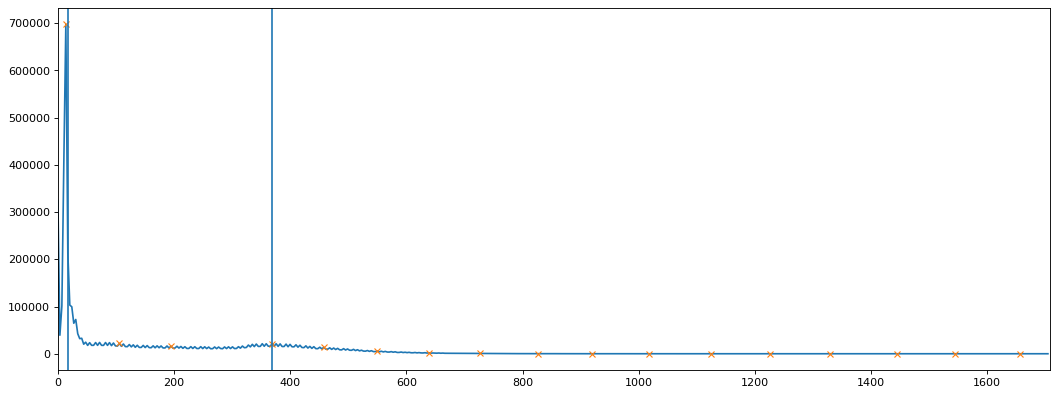

Calculated upper and lower bound: 368.928 17.08
['WC-IRB1308014251_011', 40.53623080253601, 163106.0, 163106.0, 1.8566349029541016]
img_tensor mean, std, min, max 152.4385726031135 179.11760310863966 0.0 1708.0 (256, 256, 68)
msk_tensor mean, std, min, max 0.03660000071806066 0.18777763622300173 0.0 1.0 (256, 256, 68)
Prd_tensor mean, std, min, max 0.03660000071806066 0.18777763622300173 0.0 1.0 (256, 256, 68)
67 Init types (img, msk, prd): float64 float64 float32


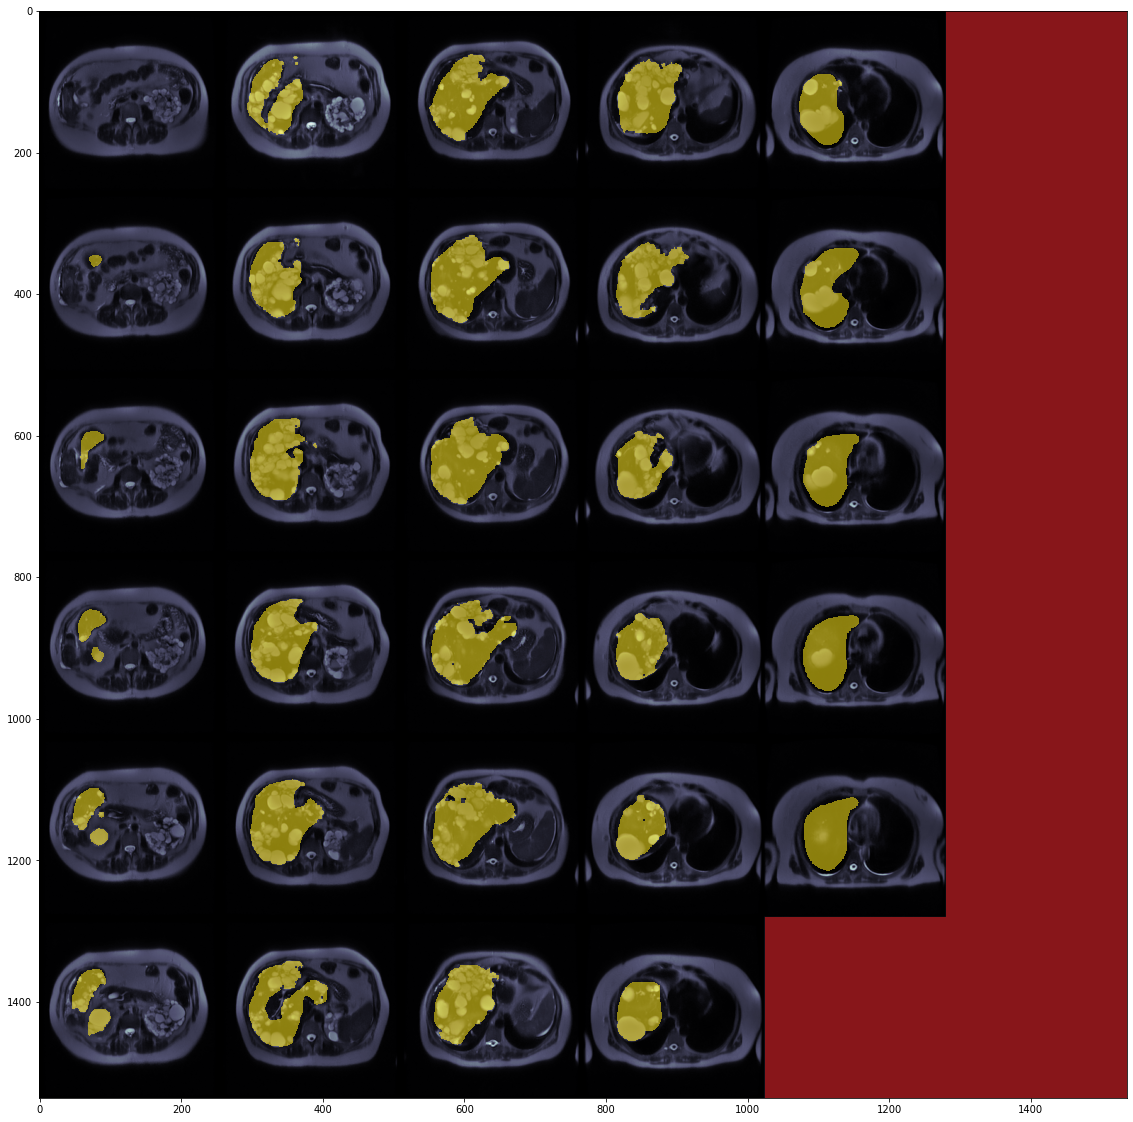

In [33]:
# Debugging
debug = True

# Dictionary to Store Times
times = []

# Get folder paths
folder_dir = organizeFolders(fp)

# Choose random image
i = '/data/Collin/Liver_Tumor_Segmentation_Methods/Fake_ISMRM_AutoLevelSet/WC-IRB1308014251_011'
# i = random.choice(folder_dir)
print('Random Image:', i)

# Get File Paths
file_dir = organizeFiles(i)
patient_id = i.split(splitter)[-1]
if debug: print('DEBUG: patient id -', patient_id, end = '\t')

# Get Image and Mask File
img, msk = None, None
for j in file_dir:
    if VOL in j:
        img = openImage(j)
    elif MSK in j:
        msk = openImage(j)
    else:
        if debug: print('ERROR: file not declared', j)

# Perform Segmentation
if img is not None and msk is not None:
    new_msk, time_taken, markers = segmentationWatershed(img[1], msk[1], verbose=True)
    
    # 'patient_id', 'time (sec)', 'liver mask voxCnt', 'liver lesion mask voxCnt', 'voxel volume'
    print([patient_id, time_taken, msk[1].sum(), new_msk.sum(), img[2]])
    
    # Show segmentation
    display2D3D(img[1], new_msk, markers, edges=False)
else:
    if debug: print('ERROR: image or mask not found for', patient_id)

In [ ]:
# Debugging
debug = False

# Dictionary to Store Times
times = []

# Get folder paths
folder_dir = organizeFolders(fp)

# Get file paths and info
for i in folder_dir:

    # Get File Paths
    file_dir = organizeFiles(i)
    patient_id = i.split(splitter)[-1]
    if debug: print('DEBUG: patient id -', patient_id, end = '\t')

    # Get Image and Mask File
    img, msk = None, None
    for j in file_dir:
        if VOL in j:
            img = openImage(j)
        elif MSK in j:
            msk = openImage(j)
        else:
            if debug: print('ERROR: file not declared', j)

    # Perform Segmentation
    if img is not None and msk is not None:
        new_msk, time_taken = segmentationLevelSet(img[1], msk[1])
        
        # 'patient_id', 'time (sec)', 'liver mask voxCnt', 'liver lesion mask voxCnt', 'voxel volume'
        times.append([patient_id, time_taken, msk[1].sum(), new_msk.sum(), img[2]])
        
        # Save Segmentation
        new_msk_fp = os.path.join(i, file_map['LS'] + '.nii.gz')
        new_msk_img = nib.Nifti1Image(new_msk, img[0].affine)
        nib.save(new_msk_img, new_msk_fp)
    else:
        if debug: print('ERROR: image or mask not found for', patient_id)

In [ ]:
# Dataframe to store time results
df = pd.DataFrame(times, columns=['patient_id', 'time (sec)', 'liver mask voxCnt', 'liver lesion mask voxCnt', 'voxel volume'])
df.head()

In [ ]:
df.to_csv('AutoLevelSetTimes_' + file_map['LS'] + '.csv')